In [1]:
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
from hydra import initialize, compose
from omegaconf import OmegaConf

import warnings
warnings.filterwarnings('ignore')

with initialize(config_path="../config/"):
    data_cfg = compose(config_name="data_path")
data_cfg = OmegaConf.create(data_cfg)

### Config data path

In [3]:
HOME_PATH = "../"
DATA_PATH = data_cfg.data.leaf_tomato_disease_path
H5_TRAIN_DATA = data_cfg.data.h5_train_features
H5_LABEL_DATA = data_cfg.data.h5_train_labels
H5_LABEL_NAME = data_cfg.data.h5_label_names
BEST_MODEL_PATH = data_cfg.data.best_model_path
REPORT_TRAINING_PATH = data_cfg.data.report_training_accuracy

data_path = os.path.join(HOME_PATH, DATA_PATH)
feature_path = os.path.join(HOME_PATH, H5_TRAIN_DATA)
label_path = os.path.join(HOME_PATH, H5_LABEL_DATA)
label_name_path = os.path.join(HOME_PATH, H5_LABEL_NAME)
best_model_path = os.path.join(HOME_PATH, BEST_MODEL_PATH)
report_training_path = os.path.join(HOME_PATH, REPORT_TRAINING_PATH)

In [5]:
label_name_path

'../data/preprocess/label_names.npz'

### Visual Testing Image

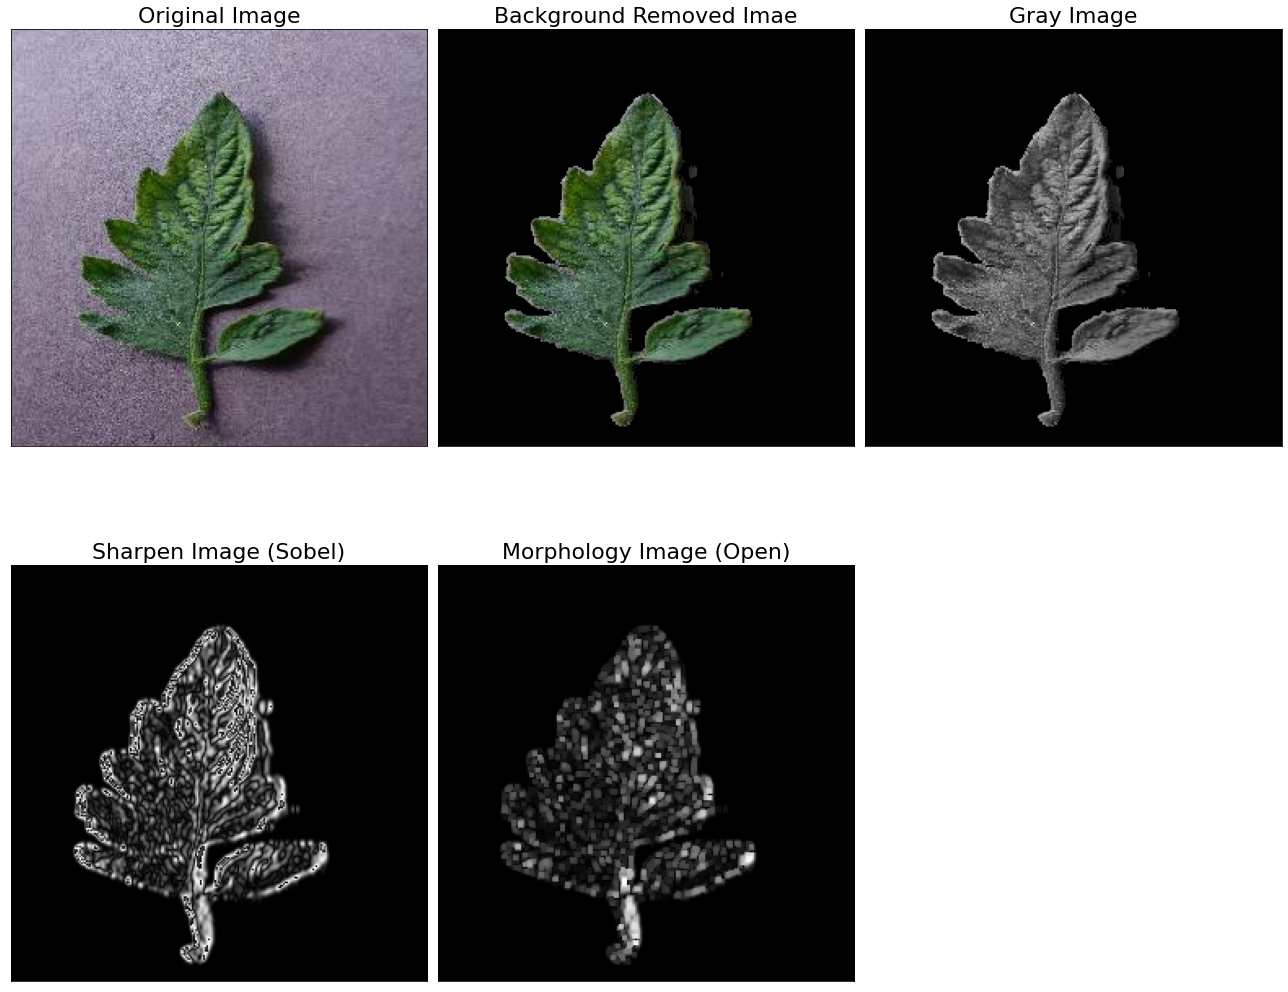

In [6]:
from image_processing import img_segmentation, sobel_edge_detection_2

image = cv2.imread("../data/plantvillage/Tomato_mosaic_virus/000ec6ea-9063-4c33-8abe-d58ca8a88878___PSU_CG 2169.JPG")

# Convert image to RGB and HSV
rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
hsv_img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
# => background removed image (image segmentation)
remove_background = img_segmentation(rgb_img, hsv_img)

# Convert to gray image
gray_img = cv2.cvtColor(remove_background, cv2.COLOR_RGB2GRAY)

# Sharpen Image (Sobel Filter)
sobel_img = sobel_edge_detection_2(gray_img)

# morphology image
kernel = np.ones((3,3),np.uint8)
MORPHOLOGY_IMG = cv2.morphologyEx(sobel_img, cv2.MORPH_OPEN, kernel)


fig = plt.figure(figsize=(18, 15))
(ax1, ax2, ax3), (ax4, ax5, ax6) = fig.subplots(2, 3)

# show original image
ax1.imshow(image[:, :, ::-1])
ax1.set_title("Original Image", fontsize=22)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

# show background removed image
ax2.imshow(remove_background)
ax2.set_title("Background Removed Imae", fontsize=22)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

# show gray image
ax3.imshow(gray_img, cmap="gray")
ax3.set_title("Gray Image", fontsize=22)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

# show sobel image
ax4.imshow(sobel_img, cmap="gray")
ax4.set_title("Sharpen Image (Sobel)", fontsize=22)
ax4.get_xaxis().set_visible(False)
ax4.get_yaxis().set_visible(False)

# show morphology image
ax5.imshow(MORPHOLOGY_IMG, cmap="gray")
ax5.set_title("Morphology Image (Open)", fontsize=22)
ax5.get_xaxis().set_visible(False)
ax5.get_yaxis().set_visible(False)

ax6.set_visible(False)

fig.tight_layout()
fig.subplots_adjust(hspace=0.025, wspace=0.025)

# plt.savefig("../images/preprocessing.png")
plt.show()


### Feature Extraction and Save to File

In [7]:
# from utils import extract_feature_to_file

# features, classes, class_name = extract_feature_to_file(data_path, feature_path, label_path)

[STATUS] Folder: Bacterial_spot: 1702it [00:20, 83.68it/s]
[STATUS] Folder: Early_blight: 800it [00:09, 82.32it/s]
[STATUS] Folder: Late_blight: 1527it [00:17, 84.85it/s]
[STATUS] Folder: Leaf_Mold: 761it [00:08, 86.88it/s]
[STATUS] Folder: Septoria_leaf_spot: 1417it [00:15, 88.59it/s]
[STATUS] Folder: Spider_mites Two-spotted_spider_mite: 1341it [00:15, 86.64it/s]
[STATUS] Folder: Target_Spot: 1123it [00:12, 86.70it/s]
[STATUS] Folder: Tomato_Yellow_Leaf_Curl_Virus: 4286it [00:52, 81.91it/s]
[STATUS] Folder: Tomato_mosaic_virus: 299it [00:03, 87.67it/s]
[STATUS] Folder: healthy: 1273it [00:14, 85.49it/s]


[STATUS] completed Feature Extraction Phase...


In [9]:
# np.savez(label_name_path, class_name)

### Load data

In [13]:
import warnings
warnings.filterwarnings('ignore')
from utils import split_data

data = np.load(label_name_path)
label_names = data["arr_0"]

(X_train, y_train), (X_test, y_test) = split_data(feature_path, label_path)
X_train.shape, X_test.shape, label_names

((34700, 532),
 (2906, 532),
 array(['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold',
        'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite',
        'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus',
        'Tomato_mosaic_virus', 'healthy'], dtype='<U36'))

### Train Single Model

#### 1. KNN

In [14]:
from define_model import model_classifiers
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

knn = model_classifiers[0][1]
knn.fit(X_train, y_train)
predicts = knn.predict(X_test)

# compute accuracy, precision, recall, f1_score
accuracy = accuracy_score(y_test, predicts)
precision = precision_score(y_test, predicts, average='macro')
recall = recall_score(y_test, predicts, average='macro')
f1 = f1_score(y_test, predicts, average='macro')

print(f"A: {accuracy} | P: {precision} | R: {recall} | F1: {f1_score}")

cm = confusion_matrix(y_test, predicts, normalize="true")

A: 0.8547832071576049 | P: 0.7970973986885399 | R: 0.8388277152652076 | F1: <function f1_score at 0x000001A188445948>


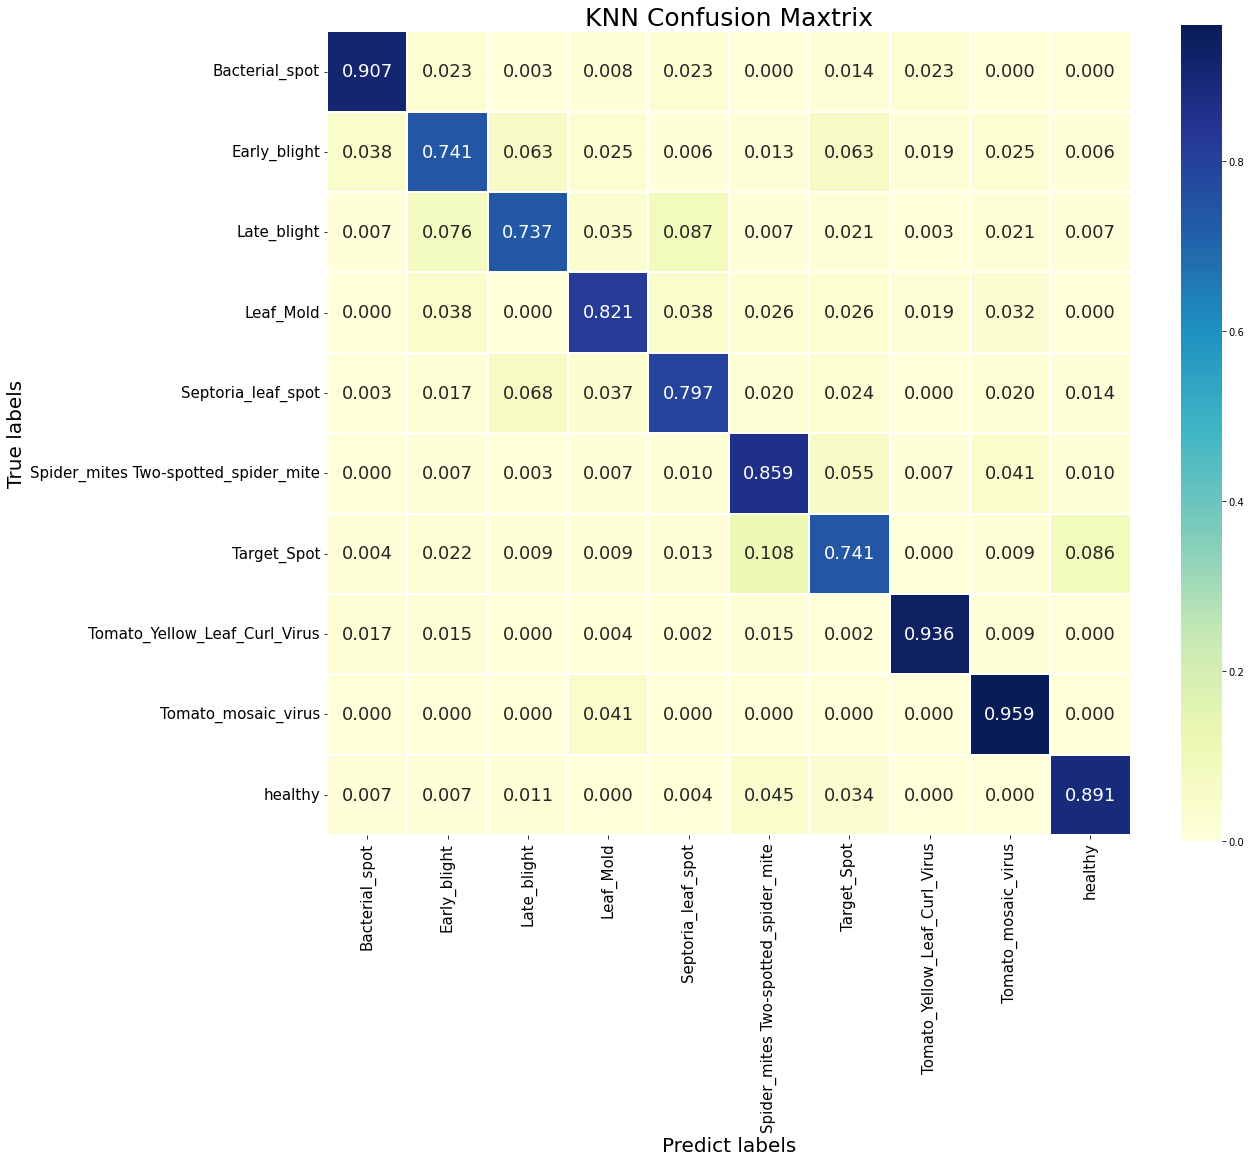

In [26]:
fig, ax = plt.subplots(figsize=(18, 15))
ax = sns.heatmap(cm, annot=True, fmt='.3f', linewidths=0.1, annot_kws={"fontsize":18}, cmap="YlGnBu", square=True)
ax.set_yticklabels(label_names, size = 15, rotation=0)
ax.set_xticklabels(label_names, size = 15, rotation=90)

ax.set_xlabel("Predict labels", size=20)
ax.set_ylabel("True labels", size=20)

ax.set_title("KNN Confusion Maxtrix", size=25)

# plt.savefig("../images/knn_cm.png")
plt.show()

#### 2. SVM: {kerne="rbf", gamma=2, C=1}

In [27]:
svc = model_classifiers[4][1]
svc.fit(X_train, y_train)
predicts = svc.predict(X_test)

# compute accuracy, precision, recall, f1_score
accuracy = accuracy_score(y_test, predicts)
precision = precision_score(y_test, predicts, average='macro')
recall = recall_score(y_test, predicts, average='macro')
f1 = f1_score(y_test, predicts, average='macro')

print(f"A: {accuracy} | P: {precision} | R: {recall} | F1: {f1_score}")

cm = confusion_matrix(y_test, predicts, normalize="true")

A: 0.9232622161046111 | P: 0.8986925095545601 | R: 0.9072186313260742 | F1: <function f1_score at 0x000001A188445948>


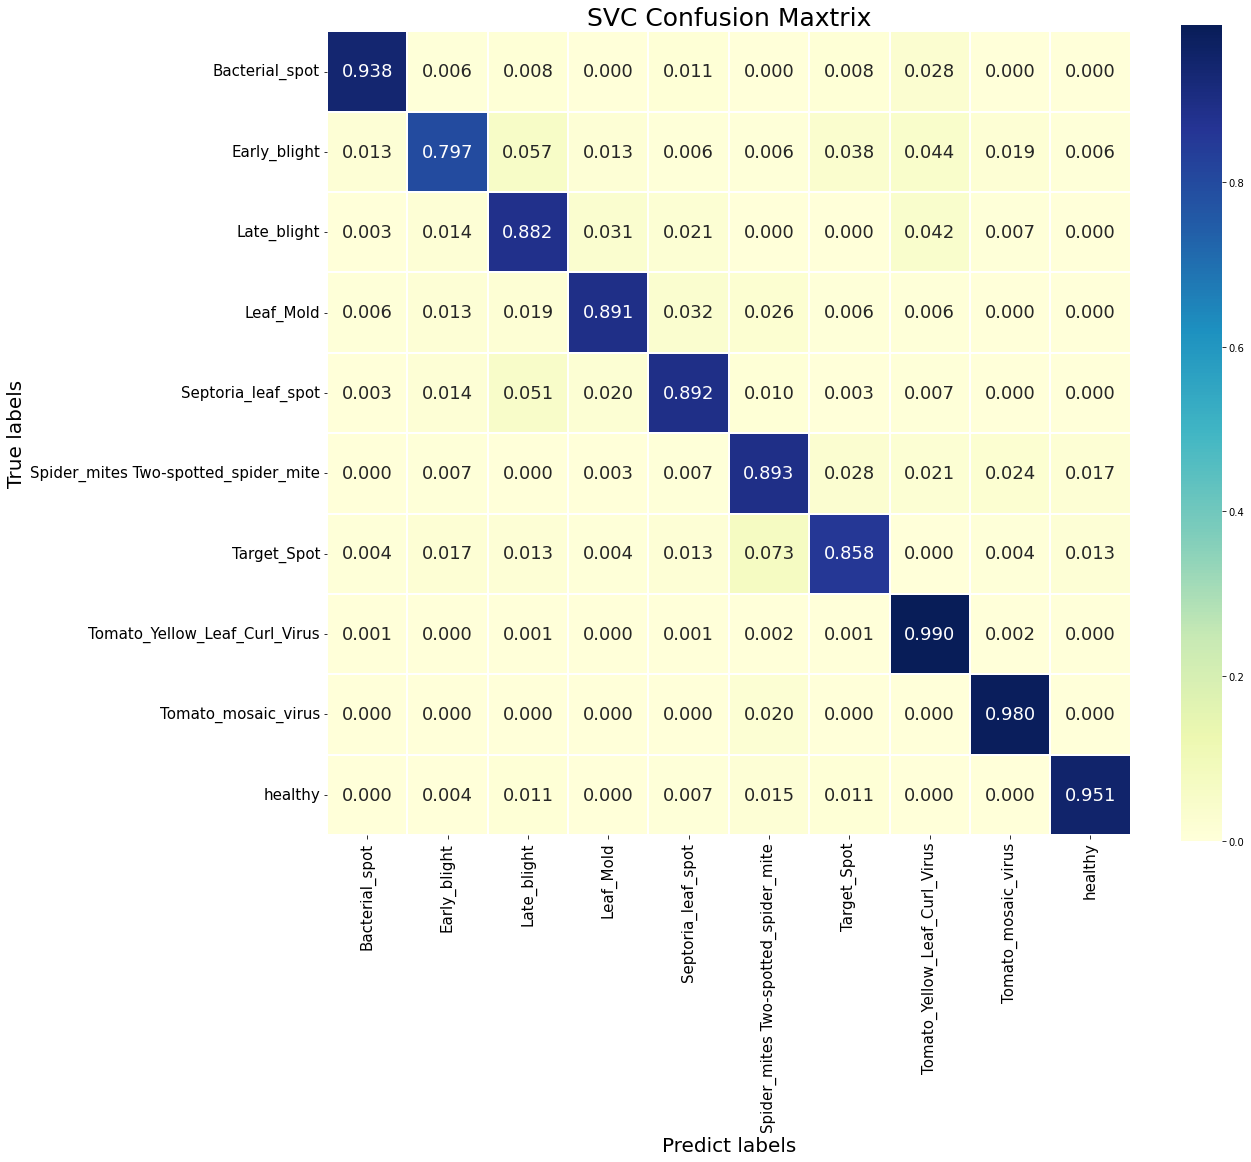

In [28]:
fig, ax = plt.subplots(figsize=(18, 15))
ax = sns.heatmap(cm, annot=True, fmt='.3f', linewidths=0.1, annot_kws={"fontsize":18}, cmap="YlGnBu", square=True)
ax.set_yticklabels(label_names, size = 15, rotation=0)
ax.set_xticklabels(label_names, size = 15, rotation=90)

ax.set_xlabel("Predict labels", size=20)
ax.set_ylabel("True labels", size=20)

ax.set_title("SVC Confusion Maxtrix", size=25)

# plt.savefig("../images/svc_cm.png")
plt.show()

#### 3. RandomForest

In [29]:
rf = model_classifiers[2][1]
rf.fit(X_train, y_train)
predicts = rf.predict(X_test)

# compute accuracy, precision, recall, f1_score
accuracy = accuracy_score(y_test, predicts)
precision = precision_score(y_test, predicts, average='macro')
recall = recall_score(y_test, predicts, average='macro')
f1 = f1_score(y_test, predicts, average='macro')

print(f"A: {accuracy} | P: {precision} | R: {recall} | F1: {f1_score}")

cm = confusion_matrix(y_test, predicts, normalize="true")

A: 0.7894012388162422 | P: 0.7365572301150416 | R: 0.781737175832162 | F1: <function f1_score at 0x000001A188445948>


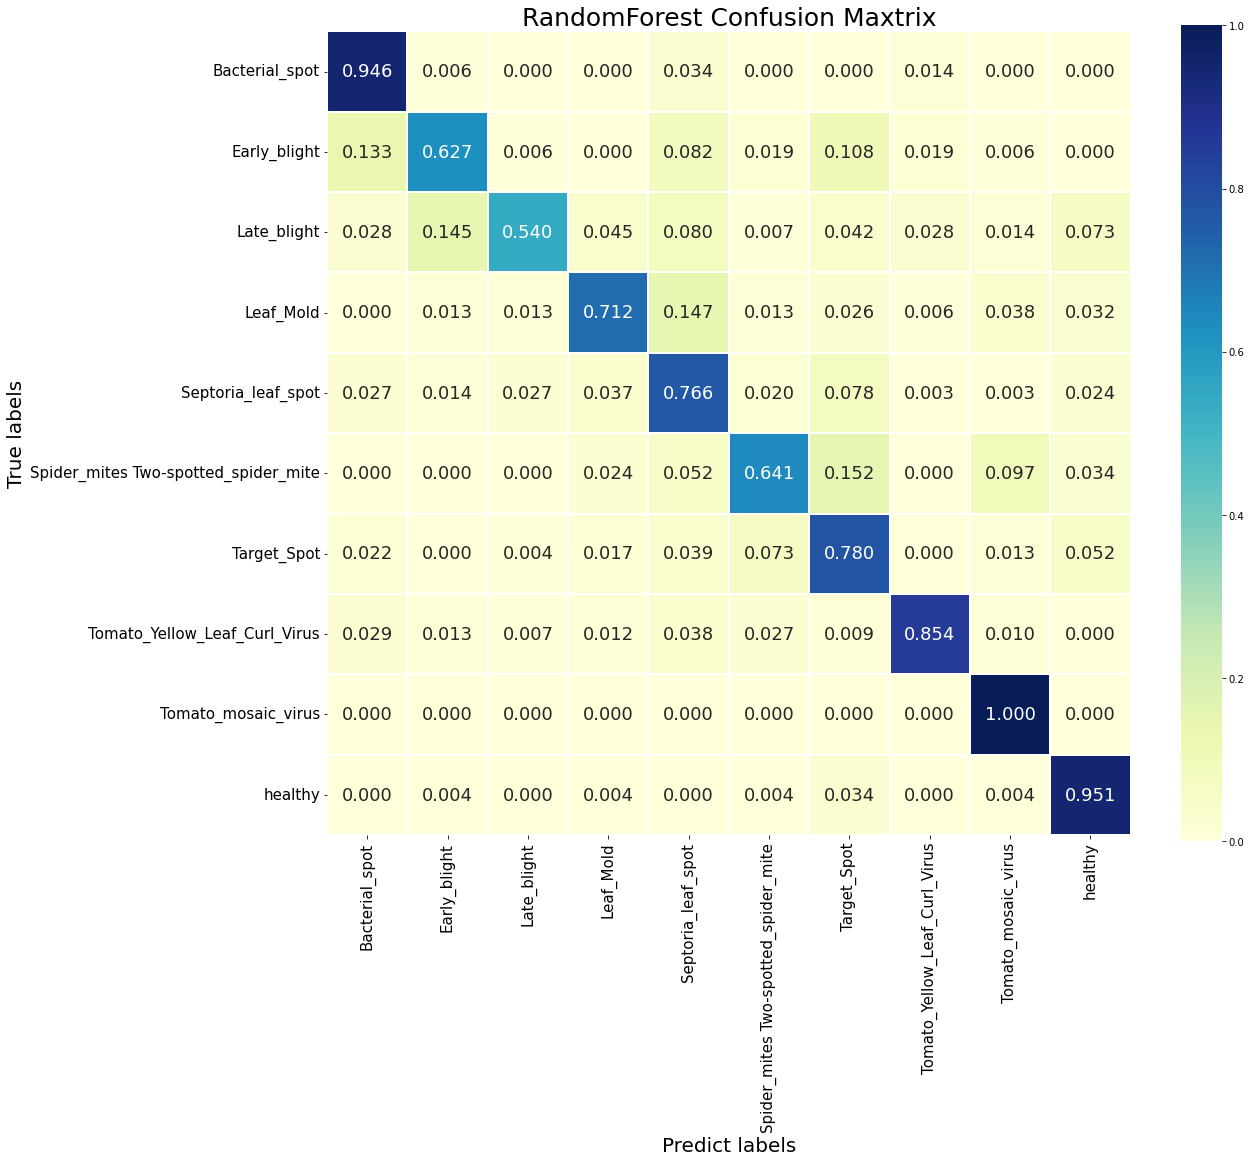

In [30]:
fig, ax = plt.subplots(figsize=(18, 15))
ax = sns.heatmap(cm, annot=True, fmt='.3f', linewidths=0.1, annot_kws={"fontsize":18}, cmap="YlGnBu", square=True)
ax.set_yticklabels(label_names, size = 15, rotation=0)
ax.set_xticklabels(label_names, size = 15, rotation=90)

ax.set_xlabel("Predict labels", size=20)
ax.set_ylabel("True labels", size=20)

ax.set_title("RandomForest Confusion Maxtrix", size=25)

# plt.savefig("../images/rf_cm.png")
plt.show()

#### 4. XGBoostClassify

In [31]:
xgb = model_classifiers[12][1]
xgb.fit(X_train, y_train)
predicts = xgb.predict(X_test)

# compute accuracy, precision, recall, f1_score
accuracy = accuracy_score(y_test, predicts)
precision = precision_score(y_test, predicts, average='macro')
recall = recall_score(y_test, predicts, average='macro')
f1 = f1_score(y_test, predicts, average='macro')

print(f"A: {accuracy} | P: {precision} | R: {recall} | F1: {f1_score}")

cm = confusion_matrix(y_test, predicts, normalize="true")

A: 0.9697178251892636 | P: 0.9603562062366813 | R: 0.9551882980874534 | F1: <function f1_score at 0x000001A188445948>


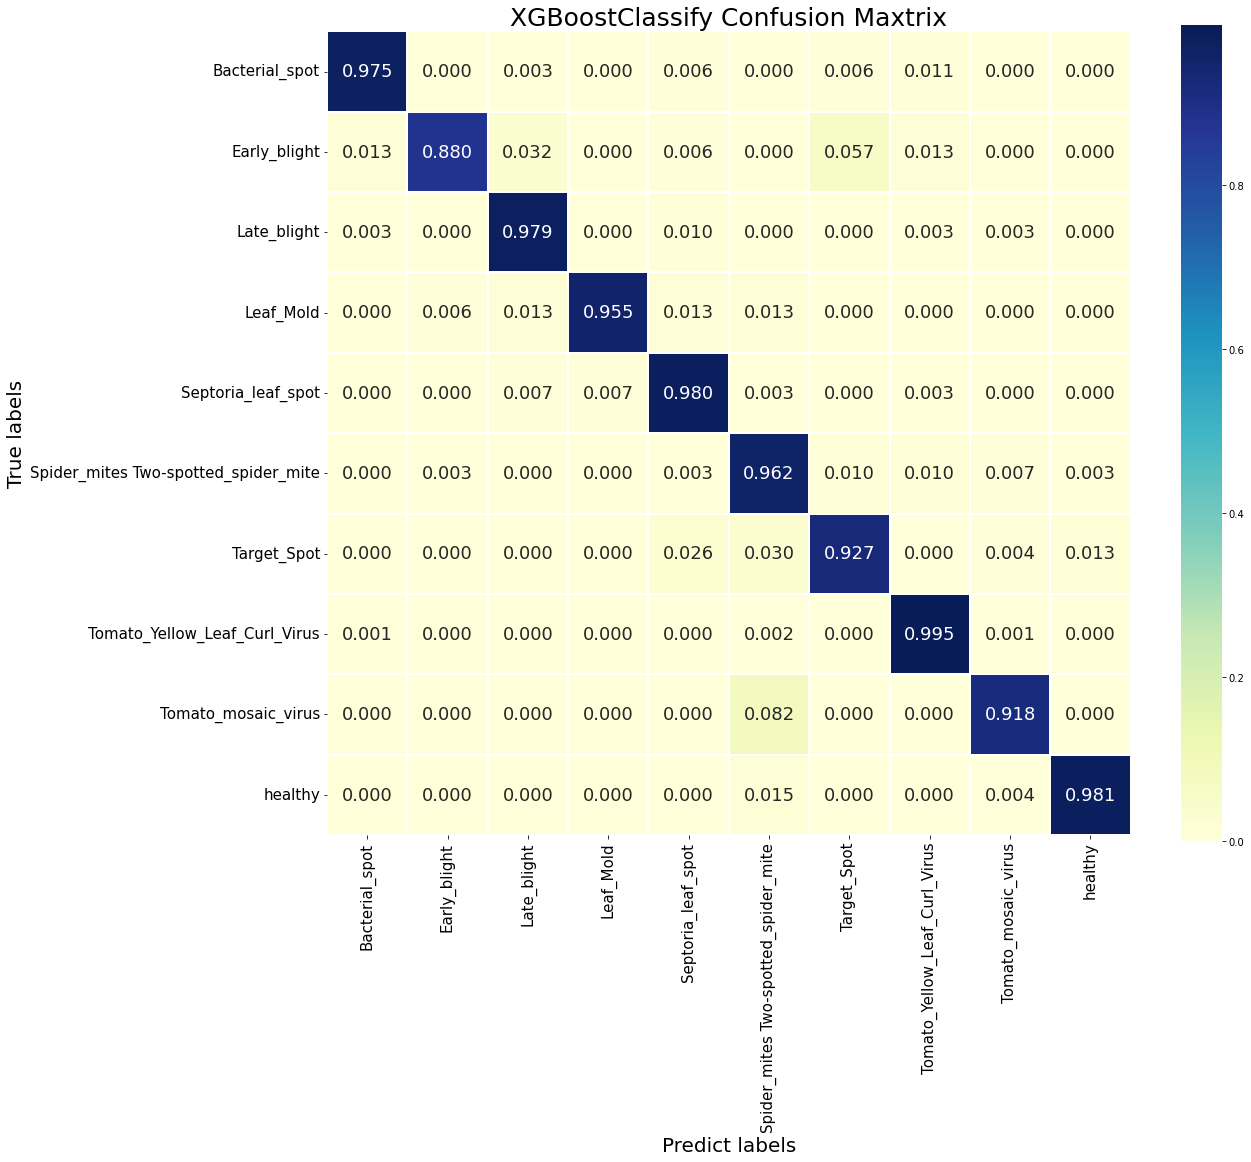

In [32]:
fig, ax = plt.subplots(figsize=(18, 15))
ax = sns.heatmap(cm, annot=True, fmt='.3f', linewidths=0.1, annot_kws={"fontsize":18}, cmap="YlGnBu", square=True)
ax.set_yticklabels(label_names, size = 15, rotation=0)
ax.set_xticklabels(label_names, size = 15, rotation=90)

ax.set_xlabel("Predict labels", size=20)
ax.set_ylabel("True labels", size=20)

ax.set_title("XGBoostClassify Confusion Maxtrix", size=25)

# plt.savefig("../images/xgb_cm.png")
plt.show()

### Tuning Model and Choose Best Model

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from define_model import model_classifiers
from utils import train_test_model_classification

log, _, _, best_model = train_test_model_classification(
    model_classifiers, 
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    report_training_path, 
    best_model_path
)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=10, reg_alpha=0, ...)

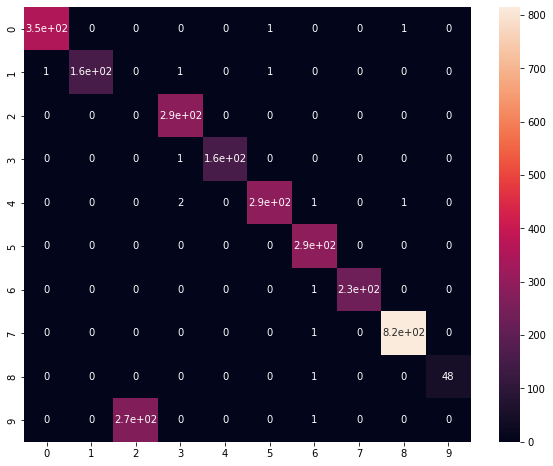

In [39]:
from sklearn.metrics import confusion_matrix
import joblib

best_model = joblib.load("../data/report/best_model.sav")
y_predict = best_model.predict(X_test)
cm = confusion_matrix(y_test,y_predict)
import seaborn as sns
plt.subplots(figsize=(10, 8))
sns.heatmap(cm ,annot=True)

best_model

In [40]:
import pandas as pd
data_df = pd.read_csv(report_training_path, header=0)
data_df

,Classifier,Accuracy,Precision,Recall,F1_Score,Trainning_Time
0,KNN,84.686855,78.902710,82.805251,80.334544,2.260089
1,Decition Tree,59.394357,58.646105,59.796727,57.155925,2.222110
2,Random Forest,79.077770,73.691811,79.317291,74.993645,7.123384
3,SVM: {linear},70.681349,64.475637,70.646684,64.574508,227.378530
4,"SVM: {gamma=2, C=1}",91.534756,89.016733,89.978285,89.396163,64.101212
5,SVM: {kernel=rbf},86.579491,81.389138,84.927326,82.807088,106.527279
6,MLP,74.363386,68.059138,73.073939,68.202607,71.696930
7,Gaussian Naive Baye,62.250516,59.178390,64.663011,58.356591,0.239467
8,Linear Discriminant Analysis,79.869236,73.758477,80.838968,75.913072,3.240517
9,Quadratic Discriminant Analysis,65.485203,65.959252,65.320374,63.157310,3.424282


In [41]:
data_df["Accuracy"].dtype

dtype('float64')

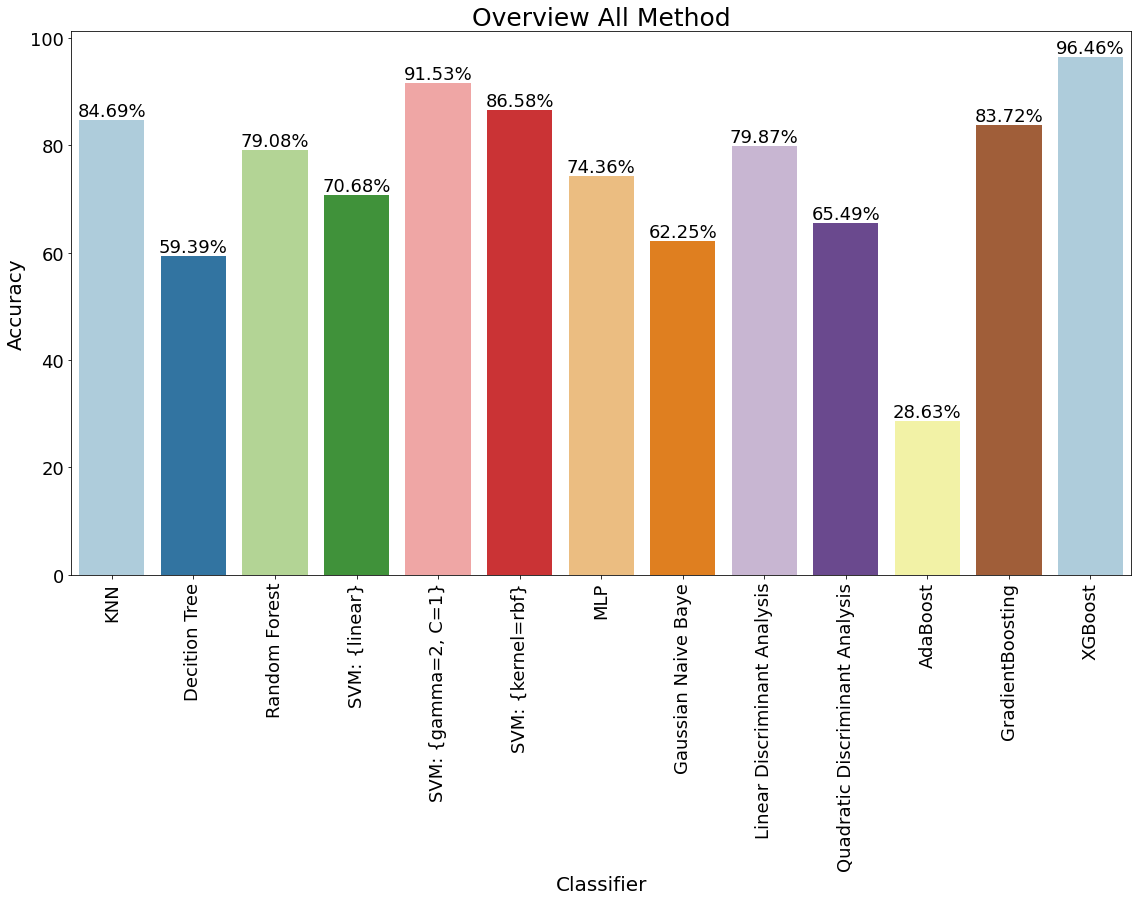

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
fig, ax= plt.subplots(figsize=(19, 10))
ax = sns.barplot(
    data=data_df, 
    x="Classifier", 
    y="Accuracy", 
    palette = 'Paired'
)

ax.set_xlabel(ax.get_xlabel(),fontsize=20)
ax.set_ylabel(ax.get_ylabel(),fontsize=20)
ax.set_title("Overview All Method", fontsize=25)

value_percent = data_df["Accuracy"].values
value_percent = [f"{v:.2f}%" for v in value_percent]

for item in ax.get_xticklabels():
    item.set_rotation(90)
    item.set_fontsize(18)

for item in ax.get_yticklabels():
    item.set_fontsize(18)

for i in ax.containers:
    ax.bar_label(i, value_percent, fontsize=18)

plt.show()